In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import os
from google.colab import files
import zipfile
import shutil

In [4]:
print("Upload your dataset ZIP file:")
uploaded_dataset = files.upload()  # Upload ZIP containing folder structure
dataset_zip = list(uploaded_dataset.keys())[0]

Upload your dataset ZIP file:


Saving straw.zip to straw (1).zip


In [9]:
base_path = '/content/dataset/straw'
splits = ['test', 'train', 'valid']
classes = ['ripe','turning','unripe']

In [13]:
for cls in classes:
    target_dir = os.path.join(base_path, cls)
    os.makedirs(target_dir, exist_ok=True)

    for split in splits:
        src_dir = os.path.join(base_path, split, cls)
        if not os.path.exists(src_dir):
            continue

        #MOVING EACH FILE
        for file in os.listdir(src_dir):
            src = os.path.join(src_dir, file)
            dst = os.path.join(target_dir, file)
            shutil.move(src, dst)


        try:
            os.rmdir(src_dir)
        except:
            pass


for split in splits:
    split_dir = os.path.join(base_path, split)
    try:
        os.rmdir(split_dir)
    except:
        pass

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#NORMALIZATION
image_size = (224, 224)
batch_size = 32
data_dir = '/content/dataset/straw'

In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 1208 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2


In [20]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False

#ADDING CLASSIFICATION LAYER
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
outputs = Dense(3, activation='softmax',kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=25)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.4095 - loss: 1.4140

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4122 - loss: 1.4103 - val_accuracy: 0.5980 - val_loss: 1.1706
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.7461 - loss: 0.9197 - val_accuracy: 0.8073 - val_loss: 0.8816
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.8792 - loss: 0.6763 - val_accuracy: 0.8804 - val_loss: 0.7266
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.8783 - loss: 0.6077 - val_accuracy: 0.8937 - val_loss: 0.6351
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step - accuracy: 0.9134 - loss: 0.5301 - val_accuracy: 0.9203 - val_loss: 0.5498
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step - accuracy: 0.9282 - loss: 0.4710 - val_accuracy: 0.9535 - val_loss: 0.4995
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.9334 - loss: 0.4588 - val_accuracy: 0.9269 - val_loss: 0.4838
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.9422 - loss: 0.4266 - val_accuracy: 0.9601 -

In [22]:
model.save('/content/strawberry.h5')

In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/content/WhatsApp Image 2025-06-18 at 12.40.04_d7e820c2.jpg'#path of test image
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  #NORMALIZATION

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class index: 1
Predicted class: turning


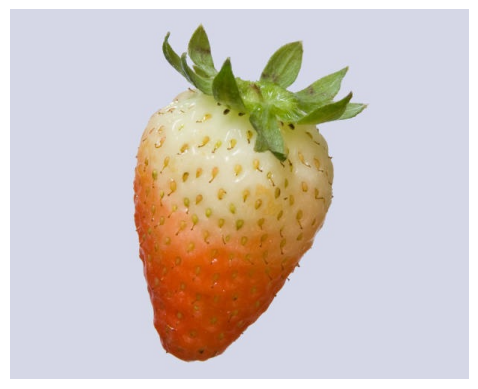

In [30]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
print("Predicted class index:", predicted_class_index)
class_names = ['ripe','turning','unripe']
print("Predicted class:", class_names[predicted_class_index])
plt.imshow(image.load_img(img_path))
plt.axis('off')
plt.show()